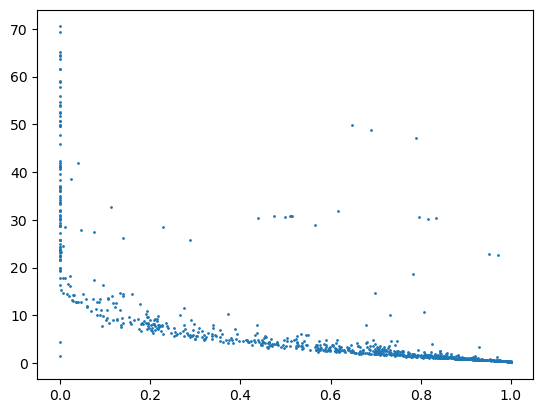

In [1]:
#IDDT versus RMSD
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt

df = pd.read_csv("output_val.csv")
rmsds = []
for pdbid in df["lig"]:
    rmsdmol = [m for m in Chem.SDMolSupplier(f"pdbbind_val_proc/{pdbid}.sdf")][0]
    rmsds.append(float(rmsdmol.GetProp("rmsd_to_crystal")))
plt.scatter(df["score"],rmsds,s=1)
plt.
plt.show()

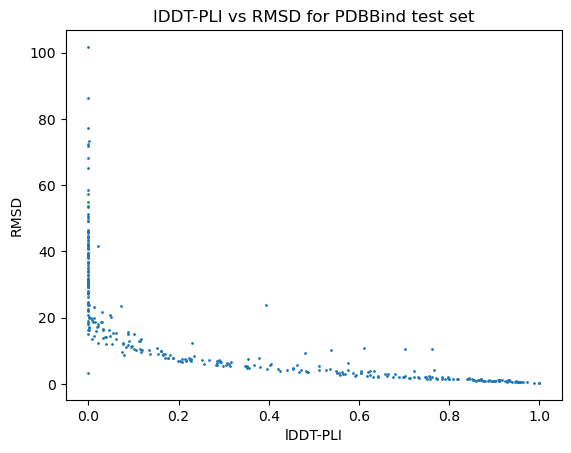

In [41]:
df = pd.read_csv("output_test.csv")
rmsds = []
for pdbid in df["lig"]:
    rmsdmol = [m for m in Chem.SDMolSupplier(f"pdbbind_test_proc/{pdbid}.sdf")][0]
    rmsds.append(float(rmsdmol.GetProp("rmsd_to_crystal")))
plt.scatter(df["score"],rmsds,s=1)
plt.title("lDDT-PLI vs RMSD for PDBBind test set")
plt.xlabel("lDDT-PLI")
plt.ylabel("RMSD")
plt.show()

In [8]:
#IDDT and protein type
from pathlib import Path
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')
pdb2uniprot = {}

Path("processed_ligands").mkdir(parents=True, exist_ok=True)
mols = [m for m in Chem.SDMolSupplier("processed_ligands_new.sdf")]
for m in mols:
    wri=Chem.SDWriter(f"processed_ligands/{m.GetProp("_Name")}.sdf")
    wri.write(m)
    wri.close()
    try:
        pdb2uniprot[m.GetProp("_Name")] = m.GetProp("_UniprotID")
    except:
        pass


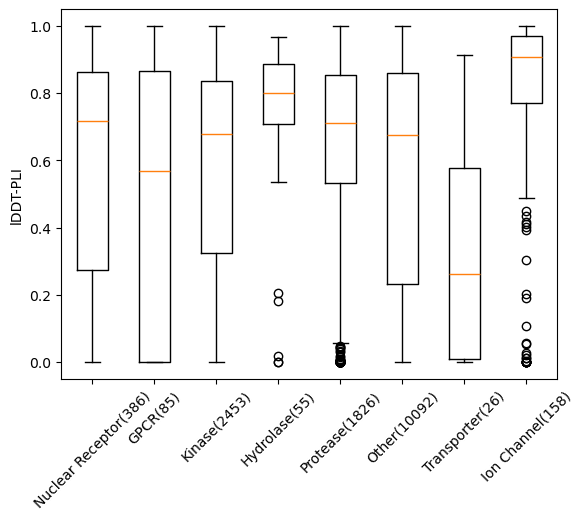

In [39]:
df = pd.read_csv("output_train.csv")
df_mapping = pd.read_csv("uniprot_mappings.csv")
uid2type = {}
for i,uid in enumerate(df_mapping["UniProt_ID"]):
    uid2type[uid] = df_mapping["Category"][i]
rmsds = {k:[] for k in set(df_mapping["Category"])}
lddts = {k:[] for k in set(df_mapping["Category"])}
for i,pdbid in enumerate(df["lig"]):
    rmsdmol = [m for m in Chem.SDMolSupplier(f"pdbbind_train_proc/{pdbid}.sdf")][0]
    uid = pdb2uniprot[pdbid]
    cat = uid2type[uid]
    rmsds[cat].append(float(rmsdmol.GetProp("rmsd_to_crystal")))
    lddts[cat].append(df["score"][i])

lddt_clean = {k:[n for n in lddts[k] if float(n)==n] for k in lddts if len(lddts[k])>10}

plt.boxplot([lddt_clean[k] for k in lddt_clean],labels = [f"{k}({len(lddt_clean[k])})" for k in lddt_clean])
plt.ylabel("lDDT-PLI")
plt.tick_params(axis='x', labelrotation=45) 
plt.show()

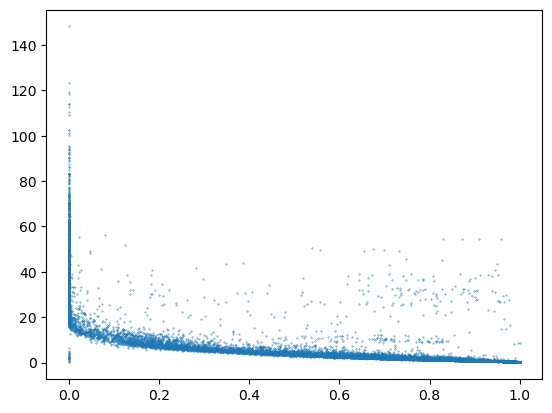

In [40]:
df = pd.read_csv("output_train.csv")
rmsds = []
for pdbid in df["lig"]:
    rmsdmol = [m for m in Chem.SDMolSupplier(f"pdbbind_train_proc/{pdbid}.sdf")][0]
    rmsds.append(float(rmsdmol.GetProp("rmsd_to_crystal")))
plt.scatter(df["score"],rmsds,s=0.1)

In [39]:
import requests
import pandas as pd
from collections import defaultdict
import gzip
from io import StringIO

# Step 1: Download UniProt to InterPro mapping
def download_uniprot_interpro_mapping():
    """Download the UniProt to InterPro mapping file"""
    url = "https://ftp.ebi.ac.uk/pub/databases/interpro/current_release/protein2ipr.dat.gz"
    
    print("Downloading UniProt-InterPro mapping (~2GB compressed)...")
    response = requests.get(url, stream=True)
    
    # Parse the gzipped file
    mappings = defaultdict(list)
    
    with gzip.open(response.raw, 'rt') as f:
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) >= 2:
                uniprot_id = fields[0]
                interpro_id = fields[1]
                mappings[uniprot_id].append(interpro_id)
    
    return dict(mappings)

# Step 2: Define InterPro ID to category mappings
INTERPRO_CATEGORIES = {
    # Kinases
    'IPR000719': 'Kinase',  # Protein kinase domain
    'IPR008271': 'Kinase',  # Serine/threonine protein kinase
    'IPR001245': 'Kinase',  # Tyrosine protein kinase
    'IPR020635': 'Kinase',  # Tyrosine protein kinase, catalytic domain
    
    # Proteases
    'IPR001254': 'Protease',  # Serine protease
    'IPR001969': 'Protease',  # Aspartic peptidase
    'IPR001930': 'Protease',  # Peptidase M1
    'IPR001506': 'Protease',  # Peptidase M12
    'IPR000994': 'Protease',  # Peptidase C1
    'IPR034148': 'Protease',  # Peptidase S1
    
    # GPCRs
    'IPR000276': 'GPCR',  # GPCR, rhodopsin-like
    'IPR017452': 'GPCR',  # GPCR, rhodopsin-like, 7TM
    'IPR000337': 'GPCR',  # GPCR, secretin-like
    'IPR000832': 'GPCR',  # GPCR, family 3
    
    # Ion Channels
    'IPR005821': 'Ion Channel',  # Ion transport protein
    'IPR001508': 'Ion Channel',  # Voltage-gated ion channel
    'IPR002394': 'Ion Channel',  # Voltage-gated potassium channel
    'IPR003079': 'Ion Channel',  # Sodium channel
    
    # Nuclear Receptors
    'IPR001628': 'Nuclear Receptor',  # Nuclear hormone receptor
    'IPR000536': 'Nuclear Receptor',  # Nuclear hormone receptor, ligand-binding
    
    # Transporters
    'IPR011701': 'Transporter',  # Major facilitator superfamily
    'IPR001757': 'Transporter',  # ATPase, P-type
    
    # Enzymes (general categories)
    'IPR016040': 'Oxidoreductase',  # NAD(P)-binding domain
    'IPR012336': 'Transferase',  # Thioredoxin-like fold
    'IPR015421': 'Hydrolase',  # Pyrophosphatase
}

def classify_by_interpro(interpro_ids):
    """Classify protein based on InterPro IDs"""
    if not interpro_ids:
        return 'Other'
    
    # Check against our category mappings
    for ipr_id in interpro_ids:
        if ipr_id in INTERPRO_CATEGORIES:
            return INTERPRO_CATEGORIES[ipr_id]
    
    return 'Other'

# Step 3: Process your UniProt IDs
def classify_proteins(uniprot_ids, mappings):
    """Classify a list of UniProt IDs"""
    results = []
    
    for uniprot_id in uniprot_ids:
        interpro_ids = mappings.get(uniprot_id, [])
        category = classify_by_interpro(interpro_ids)
        results.append({
            'UniProt_ID': uniprot_id,
            'InterPro_IDs': ','.join(interpro_ids) if interpro_ids else 'None',
            'Category': category
        })
    
    return pd.DataFrame(results)

# Main execution
if __name__ == "__main__":
    # Your list of UniProt IDs
    uniprot_ids = [pdb2uniprot[k] for k in pdb2uniprot]
    
    # Download and parse mappings
    print("Step 1: Downloading InterPro mappings...")
    mappings = download_uniprot_interpro_mapping()
    
    # Classify proteins
    print("Step 2: Classifying proteins...")
    results_df = classify_proteins(uniprot_ids, mappings)
    
    # Display results
    print("\nResults:")
    print(results_df)
    print("\nCategory distribution:")
    print(results_df['Category'].value_counts())
    
    # Save to file
    results_df.to_csv('protein_classifications.csv', index=False)
    print("\nResults saved to protein_classifications.csv")

Step 1: Downloading InterPro mappings...


KeyboardInterrupt: 

In [42]:
import requests
import pandas as pd
from time import sleep

def get_interpro_for_protein(uniprot_id):
    """Get InterPro entries for a single UniProt ID via API"""
    url = f"https://www.ebi.ac.uk/interpro/api/entry/interpro/protein/uniprot/{uniprot_id}"
    
    try:
        response = requests.get(url)
        if response.ok:
            data = response.json()
            return [entry['metadata']['accession'] for entry in data.get('results', [])]
    except:
        pass
    
    return []

def classify_proteins_via_api(uniprot_ids):
    """Classify proteins using InterPro API"""
    results = []
    
    for i, uniprot_id in enumerate(uniprot_ids):
        if i % 100 == 0:
            print(f"Processing {i}/{len(uniprot_ids)}...")
        
        interpro_ids = get_interpro_for_protein(uniprot_id)
        category = classify_by_interpro(interpro_ids)
        
        results.append({
            'UniProt_ID': uniprot_id,
            'InterPro_IDs': ','.join(interpro_ids) if interpro_ids else 'None',
            'Category': category
        })
        
        sleep(0.01)  # Be nice to the API
    
    return pd.DataFrame(results)

# Use this for your 15K proteins
results_df = classify_proteins_via_api([pdb2uniprot[k] for k in pdb2uniprot])

Processing 0/18902...
Processing 100/18902...
Processing 200/18902...
Processing 300/18902...
Processing 400/18902...
Processing 500/18902...
Processing 600/18902...
Processing 700/18902...
Processing 800/18902...
Processing 900/18902...
Processing 1000/18902...
Processing 1100/18902...
Processing 1200/18902...
Processing 1300/18902...
Processing 1400/18902...
Processing 1500/18902...
Processing 1600/18902...
Processing 1700/18902...
Processing 1800/18902...
Processing 1900/18902...
Processing 2000/18902...
Processing 2100/18902...
Processing 2200/18902...
Processing 2300/18902...
Processing 2400/18902...
Processing 2500/18902...
Processing 2600/18902...
Processing 2700/18902...
Processing 2800/18902...
Processing 2900/18902...
Processing 3000/18902...
Processing 3100/18902...
Processing 3200/18902...
Processing 3300/18902...
Processing 3400/18902...
Processing 3500/18902...
Processing 3600/18902...
Processing 3700/18902...
Processing 3800/18902...
Processing 3900/18902...
Processing 4

In [43]:
results_df.to_csv("uniprot_mappings.csv")

In [44]:
results_df

,UniProt_ID,InterPro_IDs,Category
0,Q5A4W8,"IPR001487,IPR018359,IPR027353,IPR036427,IPR038...",Other
1,P04905,"IPR003081,IPR004045,IPR004046,IPR010987,IPR036...",Other
2,D9IEF7,"IPR001165,IPR002196,IPR023346,IPR023347,IPR034...",Other
3,A2P1G9,"IPR003006,IPR003597,IPR003599,IPR007110,IPR013...",Other
4,O14757,"IPR000719,IPR008271,IPR011009,IPR017441,IPR034670",Kinase
...,...,...,...
18897,P0A7E5,"IPR004468,IPR017456,IPR017926,IPR027417,IPR029...",Other
18898,Q9NWZ3,"IPR000719,IPR001245,IPR011009,IPR011029,IPR017...",Kinase
18899,P02829,"IPR001404,IPR003594,IPR019805,IPR020568,IPR020...",Other
18900,O60885,"IPR001487,IPR018359,IPR027353,IPR031354,IPR036...",Other
